Gaël Kandel

In [1]:
# Importation des modules nécessaires
import numpy as np
import skimage as sk
from random import sample
import matplotlib.pyplot as plt
from skimage.transform import resize

from keras import Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

Quelques paramètres: 

In [2]:
n = 16          # nombre d'images sur lesquelles on va entrainer le modèle
pixels = 512    # taille souhaitée des images
epochs = 20       # nombre d'itérations de l'entrainement 
batch_size = 6    # nombre de packets d'images 

Choix aléatoire et chargement des images sur lesquelles on va entrainer le modèle :

In [ ]:
un_199 = [i for i in range(1, 200)] 
n_nombres = sample(un_199, n)

agregats = [sk.io.imread(f'TB1/image/{elt}.png') for elt in n_nombres]
agregats = [resize(agregat, (pixels, pixels)) for agregat in agregats]
agregats = np.array(agregats)


labels = [sk.io.imread(f'TB1/label/{elt}.png') for elt in n_nombres]
labels = [resize(label, (pixels, pixels)) for label in labels]
labels = np.array(labels) 

Normalisation des images :

In [4]:
def normalisation(lib_image):
    for i in range(len(lib_image)): 
        lib_image[i] = (lib_image[i] - np.min(lib_image[i])) / (np.max(lib_image[i]) - np.min(lib_image[i]))
    
normalisation(agregats)

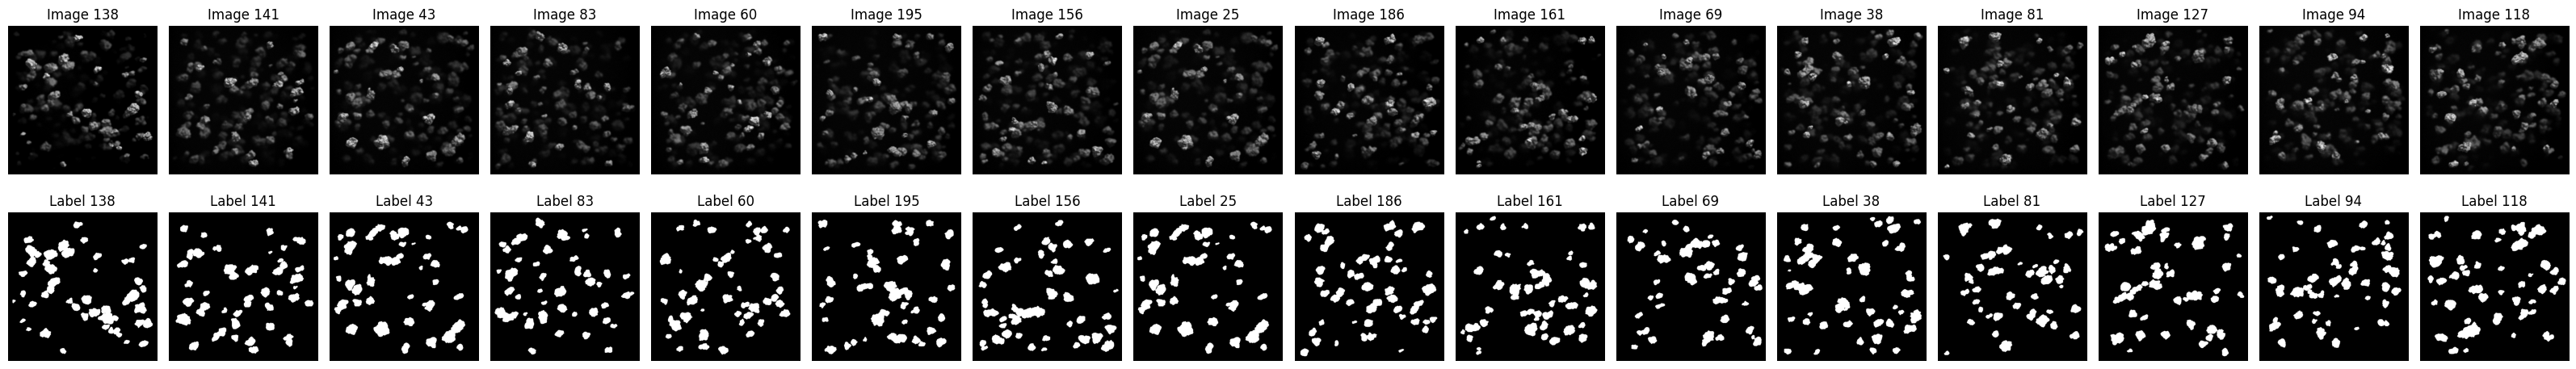

In [5]:
# Affichage des images et de leur segmentation
fig, ax = plt.subplots(2, n ,figsize=(n*2, 5))
for i in range(n):
    ax[0, i].imshow(agregats[i], cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(labels[i], cmap='gray')
    ax[1, i].axis('off')
    ax[0, i].set_title(f'Image {n_nombres[i]}')
    ax[1, i].set_title(f'Label {n_nombres[i]}')
plt.tight_layout()
plt.show()

# Apprentissage de la segmentation 


Construction d'un modèle sur la base de l'architecture UNet : 

In [6]:
def build_model(input_layer, start_neurons = 64):
    # Encoding path
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)
    
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # Decoding path
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1, 1), padding="same", activation="relu")(uconv1)

    return output_layer

img_size_target = agregats[0].shape[0]
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer)

model = Model(input_layer, output_layer)

Sur des images de taille 128x128, j'ai testé différentes fonctions d'activation et j'obtiens les meilleurs résultats avec la fonction d'activation relu. C'est pour cela que j'ai décidé d'uiliser celle-ci.

On peut observer l'architecture du modèle avec model.summary()

In [9]:
# Compilation du modèle
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [10]:
history = model.fit(agregats.reshape(n, img_size_target, img_size_target,1), 
                    labels.reshape(n, img_size_target, img_size_target, 1),
                    validation_split=0.1,
                    epochs=epochs,
                    batch_size=batch_size)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 90s 26s/step - accuracy: 0.8408 - loss: 2.8331 - val_accuracy: 0.9410 - val_loss: 0.2373
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 24s/step - accuracy: 0.9138 - loss: 0.2871 - val_accuracy: 0.9117 - val_loss: 0.1940
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 71s 21s/step - accuracy: 0.9167 - loss: 0.1855 - val_accuracy: 0.9398 - val_loss: 0.1547
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 75s 22s/step - accuracy: 0.9432 - loss: 0.1482 - val_accuracy: 0.9480 - val_loss: 0.1329
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 75s 22s/step - accuracy: 0.9513 - loss: 0.1300 - val_accuracy: 0.9491 - val_loss: 0.1374
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 77s 22s/step - accuracy: 0.9524 - loss: 0.1210 - val_accuracy: 0.9493 - val_loss: 0.1210
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 76s 22s/step - accuracy: 0.9517 - loss: 0.1165 - val_accuracy: 0.9510 - val_loss: 0.1328
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 75s 21s/step - accuracy: 0.9541 - loss: 0.1156 - val_accuracy: 0.9515 - val_loss: 0.1205


In [11]:
# Enrefistrement du modèle
model.save(f'model_{pixels}_{epochs}.keras')

Affichage de la courbe d'apprentissage :

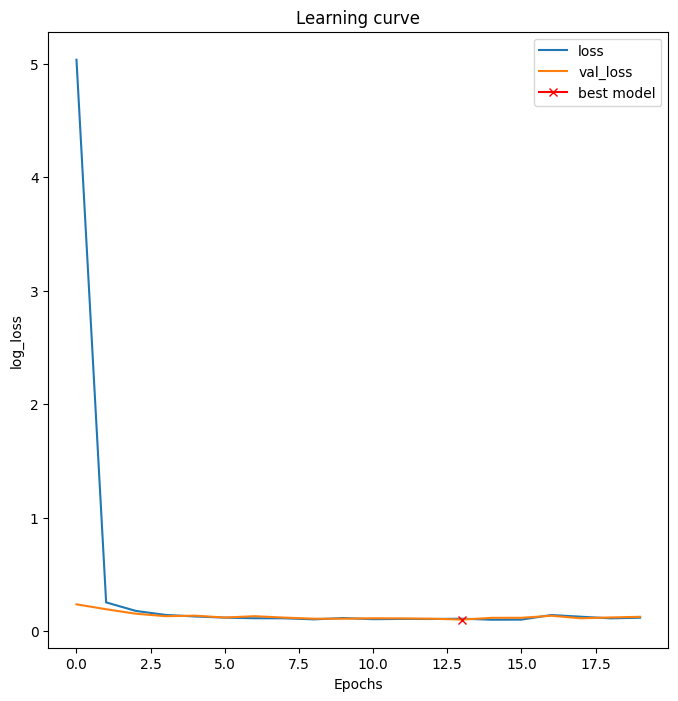

In [12]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.show()

Chargement de toute la base d'images pour tester le modèle :

In [13]:
agregats = [sk.io.imread(f'TB1/image/{elt}.png') for elt in un_199]
agregats = [resize(agregat, (pixels, pixels)) for agregat in agregats]
agregats = np.array(agregats)
normalisation(agregats)

labels = [sk.io.imread(f'TB1/label/{elt}.png') for elt in un_199]
labels = [resize(label, (pixels, pixels)) for label in labels]
labels = np.array(labels)

Méthode de binarisation d'Otsu pour mieux comparer les résultats (on aurait aussi pu utiliser différentes méthodes de traitement d'image pour "mieux" nourir nôtre modèle UNET et améliorer les résultats) :

In [14]:
def binarisation(lib_image):
    for i in range(len(lib_image)):
        seuil = sk.filters.threshold_otsu(lib_image[i])
        lib_image[i] = lib_image[i] > seuil

Prédictions : 

In [15]:
preds_train = model.predict(np.array(agregats))
preds_train = preds_train.reshape(199, pixels, pixels)
binarisation(preds_train)

7/7 ━━━━━━━━━━━━━━━━━━━━ 262s 37s/step


# Évalutation de l'efficacité de la segmentation 

Visualisation : 

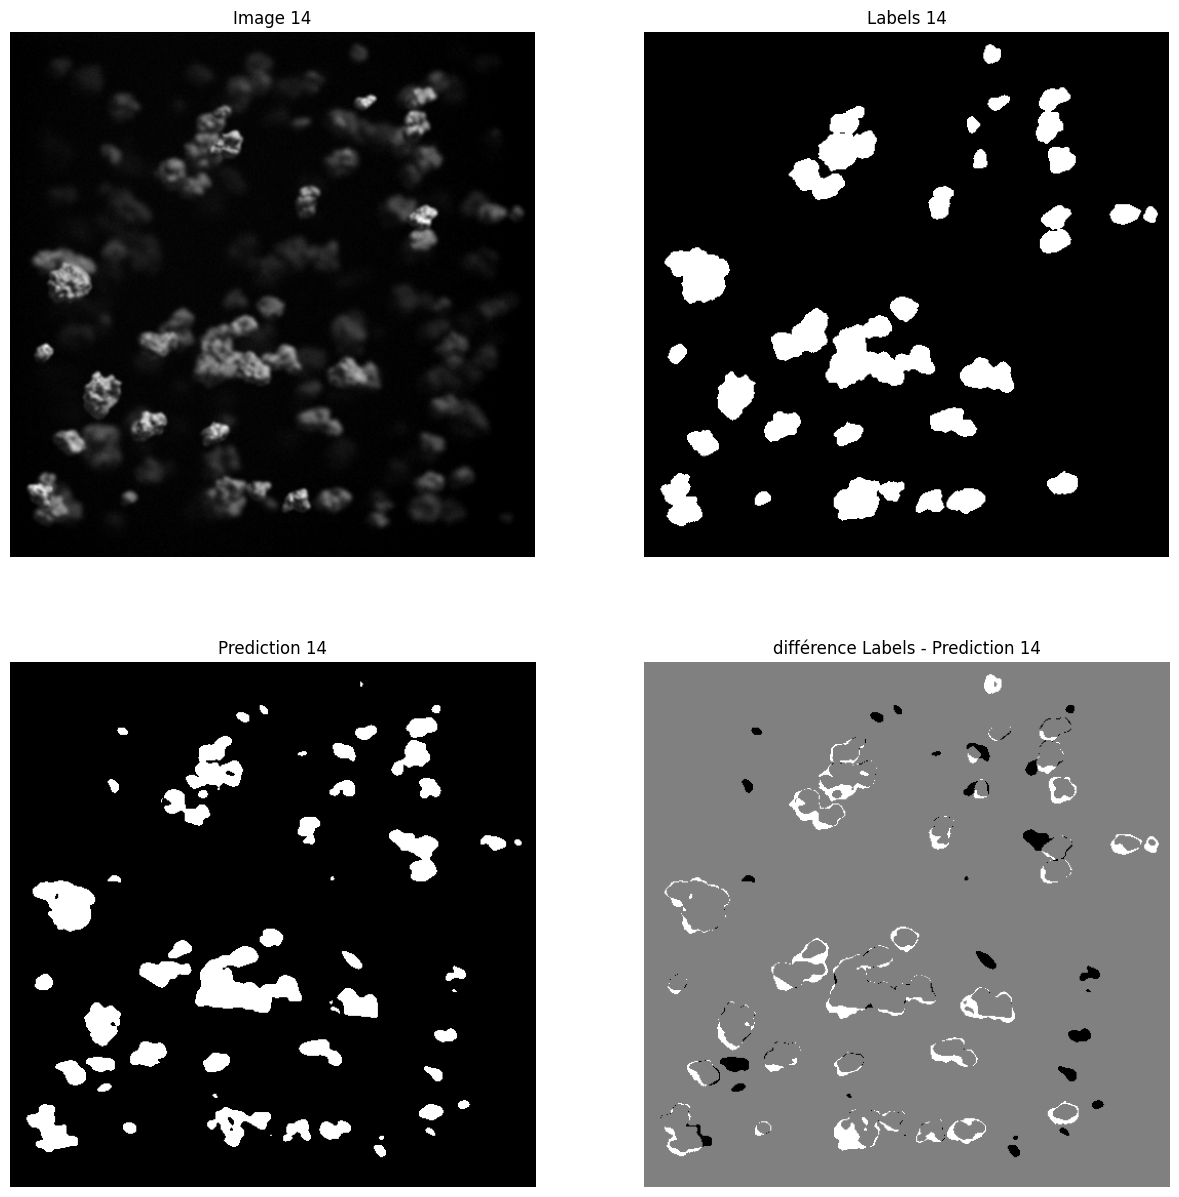

In [26]:
N = np.random.randint(0, 199)
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0, 0].imshow(agregats[N], cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].set_title(f'Image {un_199[N]}')
ax[0, 1].imshow(labels[N], cmap='gray')
ax[0, 1].axis('off')
ax[0, 1].set_title(f'Labels {un_199[N]}')
ax[1, 0].imshow(preds_train[N], cmap='gray')
ax[1, 0].axis('off')
ax[1, 0].set_title(f'Prediction {un_199[N]}')
ax[1, 1].imshow(((labels[N].astype(np.uint8)-preds_train[N])), cmap='gray')
ax[1, 1].axis('off')
ax[1, 1].set_title(f'différence Labels - Prediction {un_199[N]}')

plt.show()

On observe sur l'image des différences que notre modèle marque les agrégats de manière moins épaisse (zones blanches). Une ouverture pourrait ainsi améliorer son efficacité. De plus, on remarque que notre modèle labélise des agrégats qui ne sont pas présents parmi les labels fournis (zones noires). Cela peut être dû au choix de normalisation des images car ces agrégats en plus sont ceux plus "en profondeur" dans l'image. Finalement, quelques agrégats sont divisés en deux alors que d'autres sont rassemblés en un seul.

Statistiques du modèle

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [18]:
# Matrice de confusion
y_pred = preds_train.flatten().astype(np.uint8)
y_true = np.array(labels).flatten().astype(np.uint8)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[45902798   830842]
 [ 1521212  3911804]]


In [19]:
# Rapport de classification
print(classification_report(y_true, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9679    0.9822    0.9750  46733640
           1     0.8248    0.7200    0.7689   5433016

    accuracy                         0.9549  52166656
   macro avg     0.8964    0.8511    0.8719  52166656
weighted avg     0.9530    0.9549    0.9535  52166656



In [20]:
# precision
precision = precision_score(y_true, y_pred)
precision

0.8248146709663762

Cette précision est peu satisfaisante, j'obtenais 0.87 avec des images 128x128 sur un nombre d'entrainements plus grand. Je me suis limité à 20 itérations pour des raisons de mémoire vive pour les images de 512x512.